In [58]:
# import flappy_bird_gymnasium  
import gymnasium as gym
import gymnasium.utils.play
import matplotlib.pyplot as plt
import numpy as np
import pygame
import time
import torch
import torch.nn as nn
import torch.optim as optim
import random
from gymnasium.wrappers import RecordVideo

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## **Human play**

In [32]:
env = gym.make("FlappyBird-v0", render_mode="rgb_array")

gymnasium.utils.play.play(env, zoom=1.5, keys_to_action={(pygame.K_UP,): 1}, noop=0)

c:\Users\aleja\workspace\RLGAN-project-MAADM-UPM\.venv_torch\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\aleja\workspace\RLGAN-project-MAADM-UPM\.venv_torch\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


## **MLP arquitecture**

In [81]:
class Torch_MLP(nn.Module):
    def __init__(self, layer_dims: list):
        super(Torch_MLP, self).__init__()
        layers = []
        for i in range(len(layer_dims) - 1):
            layers.append(nn.Linear(layer_dims[i], layer_dims[i + 1]))
            if i < len(layer_dims) - 2:  # No ReLU on the output layer
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(0.1))
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

    def print_num_parameters(self):
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Total number of parameters: {total_params}")

## **Agent play**

In [ ]:
env = gym.make("FlappyBird-v0", use_lidar=False)
observation_space = env.observation_space.shape[0] # 12
action_space = int(env.action_space.n) # 2

layer_dims = [observation_space] + [128,128,64] + [action_space]
model = Torch_MLP(layer_dims)
model.print_num_parameters()
model.to(device)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

EPISODES = 1000
trace = 50
gamma = 0.99
epsilon = 1
epsilon_min = 0.1

episode_reward_history = []

start = time.time()
for episode in range(EPISODES):
    state, _ = env.reset()
    state = torch.FloatTensor(state).to(device)
    done = False
    episode_reward = 0

    while not done:
        q_values = model(state)
        if np.random.rand() < epsilon:  # Explorar
            action = env.action_space.sample()
        else:  # Explotar
            action = torch.argmax(q_values).item()

        next_state, reward, done, _, _ = env.step(action)
        next_state = torch.FloatTensor(next_state).to(device)
        episode_reward += reward

        # Compute target
        with torch.no_grad():
            target = reward + gamma * torch.max(model(next_state)) * (1 - done)
        target = torch.FloatTensor([target]).to(device)

        q_value = q_values[action]
        loss = loss_function.forward(q_value, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state

    epsilon = max(epsilon_min, 1 - episode / (EPISODES * 0.5))  # Decay lineal
    episode_reward_history.append(episode_reward)
    
    if (episode + 1) % trace == 0 or episode == EPISODES - 1:
        print(f"Episode {episode + 1}, Episode Reward: {episode_reward}")
        
env.close()

torch.save(model.state_dict(), f"results_p1/flappy_bird_MLP_{EPISODES}.pt")
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo entreno: {int(minutos)} minutos {segundos:.2f} segundos*******")

Total number of parameters: 9282


c:\Users\aleja\workspace\RLGAN-project-MAADM-UPM\.venv_torch\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 50, Episode Reward: -8.099999999999998
Episode 100, Episode Reward: -7.499999999999998
Episode 150, Episode Reward: -7.499999999999998
Episode 200, Episode Reward: -5.699999999999998
Episode 250, Episode Reward: -3.299999999999998
Episode 300, Episode Reward: 3.8999999999999986
Episode 350, Episode Reward: 3.8999999999999986
Episode 400, Episode Reward: 3.8999999999999986
Episode 450, Episode Reward: 3.8999999999999986
Episode 500, Episode Reward: -2.099999999999998
Episode 550, Episode Reward: 3.8999999999999986
Episode 600, Episode Reward: 3.8999999999999986
Episode 650, Episode Reward: 3.8999999999999986
Episode 700, Episode Reward: -3.299999999999998
Episode 750, Episode Reward: -0.8999999999999982
Episode 800, Episode Reward: -0.8999999999999986
Episode 850, Episode Reward: -0.8999999999999986
Episode 900, Episode Reward: 0.3000000000000007
Episode 950, Episode Reward: -0.8999999999999982
Episode 1000, Episode Reward: 3.8999999999999986
*******Tiempo entreno: 1 minutos 33.

## **Reward history**

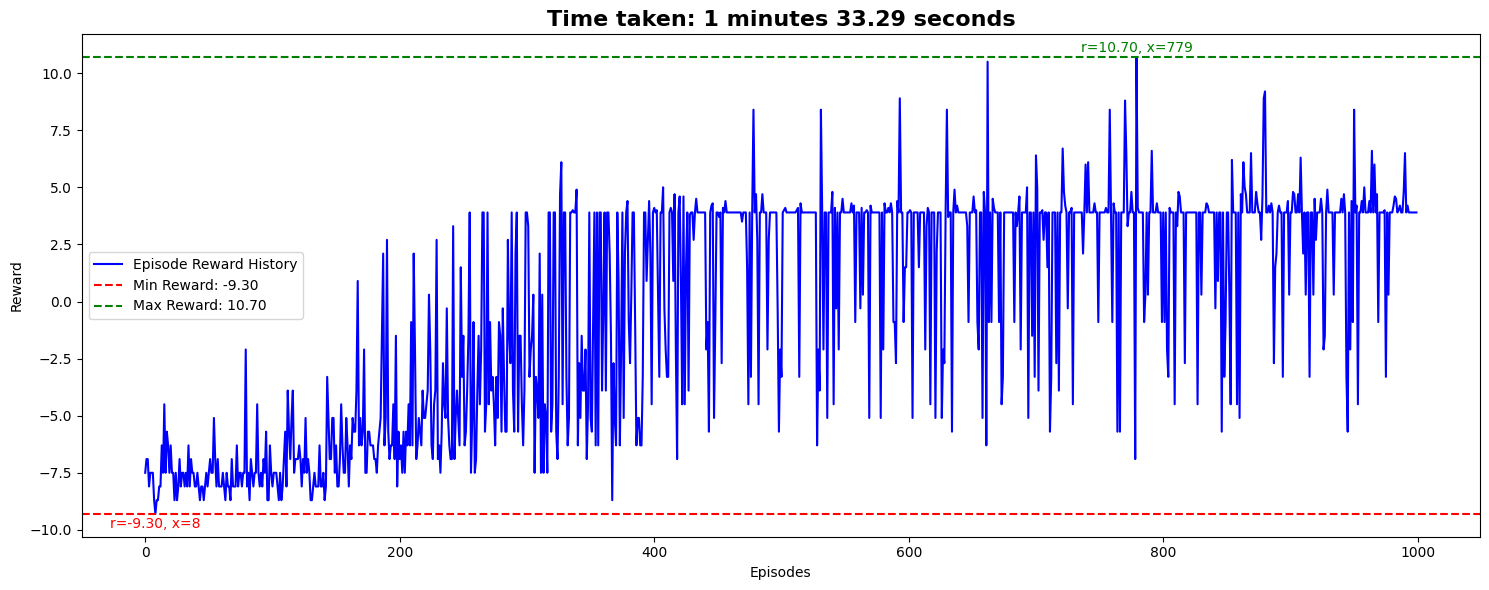

In [89]:
plt.figure(figsize=(15, 6))
plt.plot(range(EPISODES), episode_reward_history, label='Episode Reward History', color='blue')

# Adding min and max bars
min_reward = min(episode_reward_history)
max_reward = max(episode_reward_history)
min_episode = episode_reward_history.index(min_reward)
max_episode = episode_reward_history.index(max_reward)

plt.axhline(y=min_reward, color='red', linestyle='--', label=f'Min Reward: {min_reward:.2f}')
plt.axhline(y=max_reward, color='green', linestyle='--', label=f'Max Reward: {max_reward:.2f}')

# Get current y-axis limits and compute an offset (2% of y-range)
ax = plt.gca()
ymin_axis, ymax_axis = ax.get_ylim()
offset = (ymax_axis - ymin_axis) * 0.01

# Adjust offsets; change sign as needed (positive: above, negative: below)
min_offset = -offset-0.4  # places min text below the line
max_offset = offset   # places max text above the line

plt.text(min_episode, min_reward + min_offset, f"r={min_reward:.2f}, x={min_episode}", color='red', ha='center')
plt.text(max_episode, max_reward + max_offset, f"r={max_reward:.2f}, x={max_episode}", color='green', ha='center')

plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title(f"Time taken: {int(minutos)} minutes {segundos:.2f} seconds", fontsize=16, ha='center', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig(f"results_p1/flappy_bird_MLP_{EPISODES}.png")
plt.show()

## **Test model**

In [70]:
test_model = Torch_MLP(layer_dims)
test_model.load_state_dict(torch.load("results_p1/flappy_bird_MLP_1000.pt", weights_only=True))
test_model.eval()

num_episodes_test = 3
destiny_folder = "results_p1/videos"
test_env = gym.make("FlappyBird-v0", render_mode="rgb_array", use_lidar=False)
test_env = RecordVideo(test_env, video_folder=destiny_folder, name_prefix="FB-MLP", episode_trigger=lambda x: x < num_episodes_test)  

def policy(state, epsilon=0.10):
    if random.random() < epsilon:
        return test_env.action_space.sample()  # Explore
    else:
        state_tensor = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():  # Disable gradient calculation
            action_values = test_model(state_tensor)
        return torch.argmax(action_values).item()  # Exploit

state, _ = test_env.reset()
for episode in range(num_episodes_test):
    done = False
    total_reward = 0
    
    while not done:
        action = policy(state)  
        next_state, reward, done, _, _ = test_env.step(action) 
        total_reward += reward
        state = next_state

        if done:
            print(f"Episode {episode + 1}: Total Reward = {total_reward}")
            state, _ = test_env.reset()
            break  # pasar al siguiente

test_env.close()

Episode 1: Total Reward = 3.8999999999999986
Episode 2: Total Reward = 3.9999999999999982
Episode 3: Total Reward = 18.200000000000014
